## Residual Network 구현 및 학습

>### Residual Unit -> Residual Layer -> Residual Net

In [17]:
import tensorflow as tf
import numpy as np

## 하이퍼 파라미터

In [18]:
EPOCHS = 10

## Residual Unit 구현

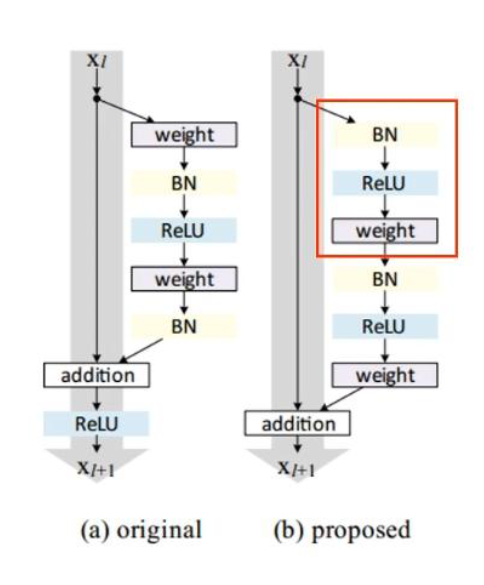

In [19]:
class ResidualUnit(tf.keras.Model):
    
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h

## Residual Layer 구현

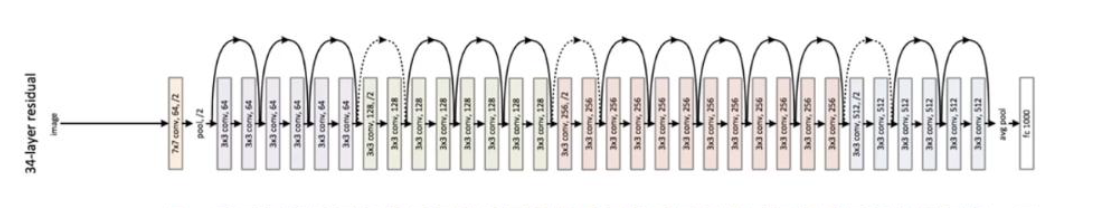

In [20]:
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters): # ex. zip([8,16,16],[16,16])
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x

## 모델 정의

In [21]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__() # ex. input : 28*28*n
        self.conv1 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.res1 = ResnetLayer(8, (16, 16), (3, 3)) # 28x28x16
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2)) # 14x14x16
        
        self.res2 = ResnetLayer(16, (32, 32), (3, 3)) # 14x14x32
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        self.res3 = ResnetLayer(32, (64, 64), (3, 3)) # 7x7x64
        
        self.flatten = tf.keras.layers.Flatten() # 3136
        self.dense1 = tf.keras.layers.Dense(128, activation='relu') # 128
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax') # 10 ( classify to number 0 ~ 9)
        
    def call(self, x, training=False, mask=None):
        x = self.conv1(x)
        
        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)
        

## 학습, 테스트 루프 정의

In [22]:
# Implement training loop
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

# Implement algorithm test
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images, training=False)

    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

## 데이터셋 준비


In [23]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 학습 환경 정의
### 모델 생성, 손실함수, 최적화 알고리즘, 평가지표 정의

In [24]:
# Create model
model = ResNet()

# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## 학습 루프 동작

In [25]:
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.1362374722957611, Accuracy: 96.26166534423828, Test Loss: 0.043587375432252884, Test Accuracy: 98.6500015258789
Epoch 2, Loss: 0.09931698441505432, Accuracy: 97.2874984741211, Test Loss: 0.046643007546663284, Test Accuracy: 98.68999481201172
Epoch 3, Loss: 0.0823485255241394, Accuracy: 97.7411117553711, Test Loss: 0.044813815504312515, Test Accuracy: 98.79666900634766
Epoch 4, Loss: 0.07157806307077408, Accuracy: 98.02749633789062, Test Loss: 0.04259391874074936, Test Accuracy: 98.84249877929688
Epoch 5, Loss: 0.06405625492334366, Accuracy: 98.22633361816406, Test Loss: 0.04102792590856552, Test Accuracy: 98.85600280761719
Epoch 6, Loss: 0.05831533297896385, Accuracy: 98.37750244140625, Test Loss: 0.04298485442996025, Test Accuracy: 98.81666564941406
Epoch 7, Loss: 0.05337631702423096, Accuracy: 98.5088119506836, Test Loss: 0.04212458059191704, Test Accuracy: 98.83428955078125
Epoch 8, Loss: 0.04950246587395668, Accuracy: 98.61895751953125, Test Loss: 0.041474748402833